In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
lr = 2e-4
latent_dim = 256
batch_size = 64 if device.type == 'cuda' else 32

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator, discriminator

(Generator(
   (model): Sequential(
     (0): Linear(in_features=256, out_features=12544, bias=True)
     (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.01, inplace=True)
     (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
     (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): LeakyReLU(negative_slope=0.01, inplace=True)
     (7): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (8): Tanh()
   )
 ),
 Discriminator(
   (model): Sequential(
     (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.01, inplace=True)
     (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): Le

In [7]:
loss = torch.nn.BCELoss()

optim_g = torch.optim.Adam(generator.parameters(), lr=lr)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
from tqdm import trange
epochs = 20

imgs = []
for e in range(epochs):
  g_running, d_running = 0, 0
  t = tqdm(train_dataloader)
  for i, (x, _) in enumerate(t):
    x = x.to(device)

    label_smoothing = (torch.randn((batch_size, 1)) * 0.05).abs().clamp(0.0, 0.3).to(device)
    fake = torch.zeros((batch_size, 1)).to(device) + label_smoothing
    valid = torch.ones((batch_size, 1)).to(device) - label_smoothing

    # train generator
    optim_g.zero_grad(set_to_none=True)
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_x = generator(z)
    g_loss = loss(discriminator(fake_x), valid) # generator wants discriminator to think its output is valid
    g_loss.backward()
    optim_g.step()

    # train discriminator
    optim_d.zero_grad(set_to_none=True)
    fake_loss = loss(discriminator(fake_x.detach()), fake)
    real_loss = loss(discriminator(x), valid)
    d_loss = (fake_loss + real_loss) / 2
    d_loss.backward()
    optim_d.step()

    g_running += g_loss.item()
    d_running += d_loss.item()
    if i % 25 == 0:
      t.set_description(f"Epochs {e+1}/{epochs} - G loss: {g_running/49:.4f} - D loss: {d_running/49:.4f}")
      g_running, d_running = 0, 0
  grid = make_grid(fake_x.cpu().detach()[:100], nrow=10).detach()
  img = (np.transpose(grid.numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
  imgs.append(img)

Epochs 20/20 - G loss: 1.3651 - D loss: 0.1133: 100%|██████████| 937/937 [00:22<00:00, 40.97it/s]


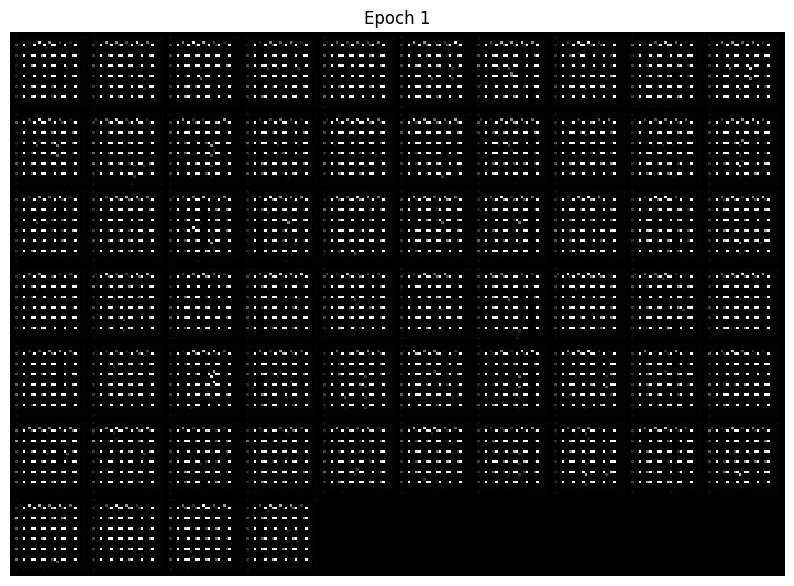

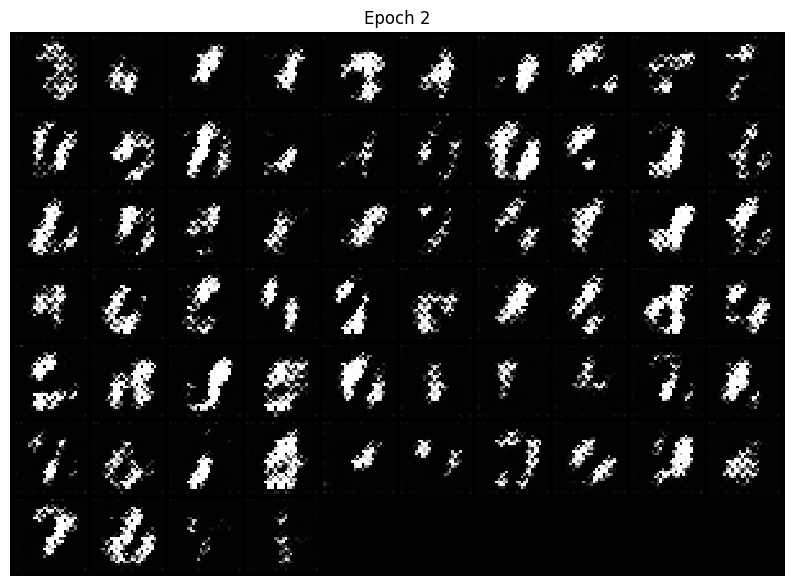

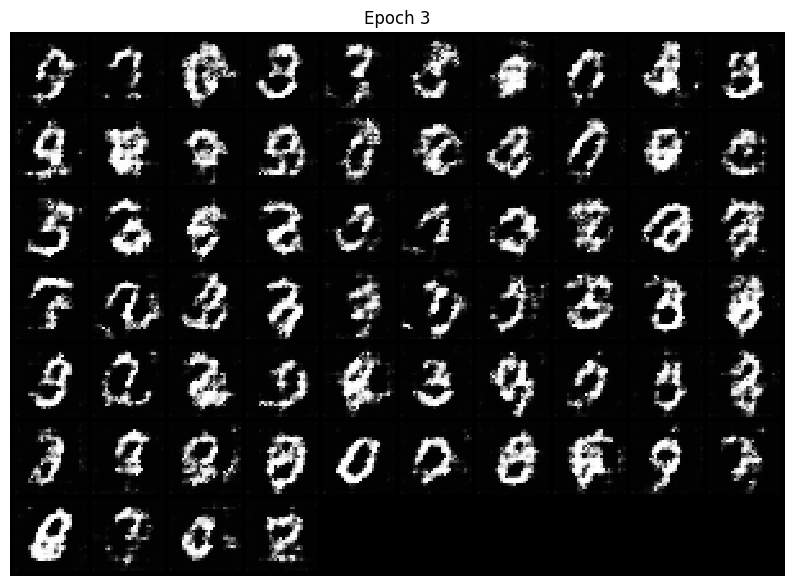

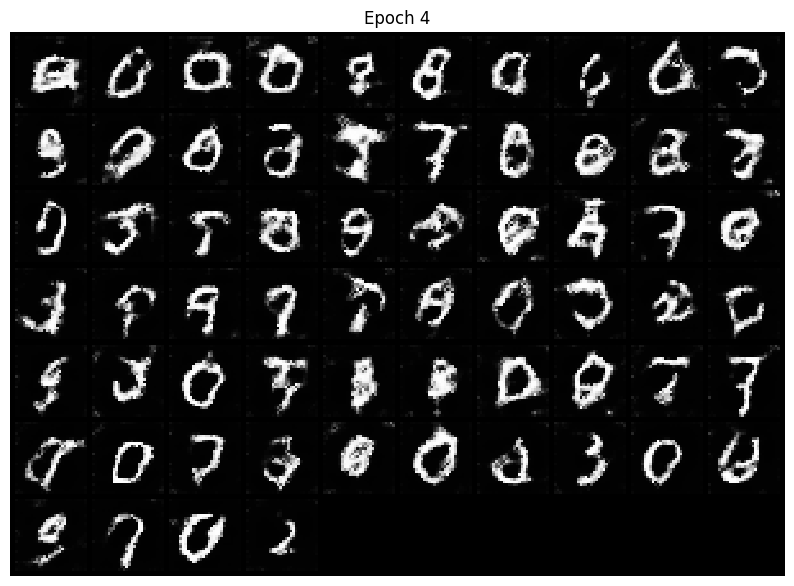

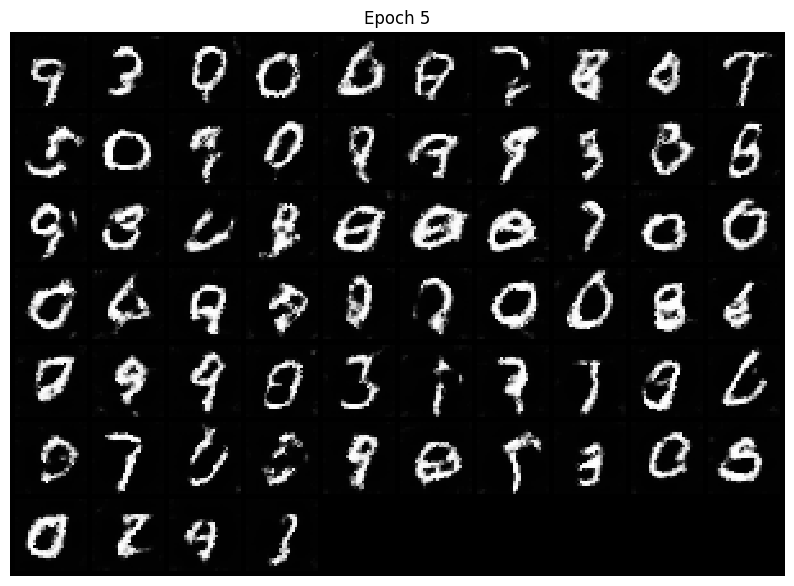

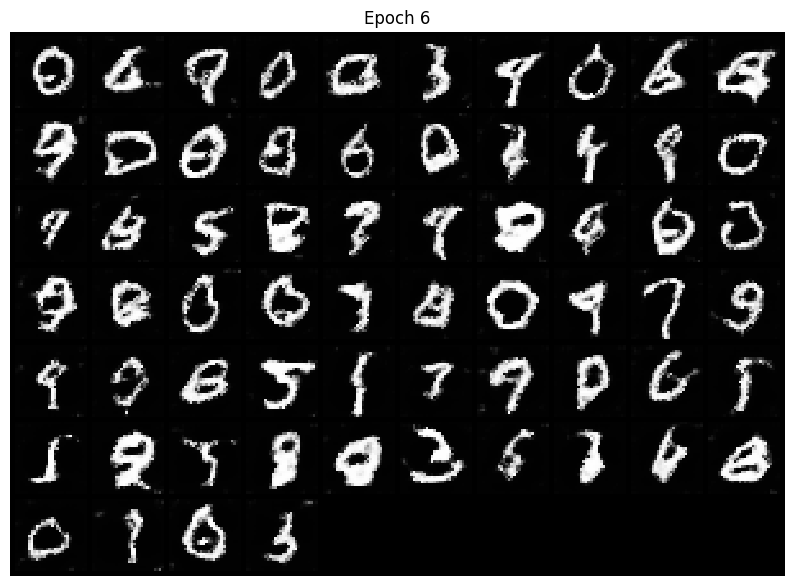

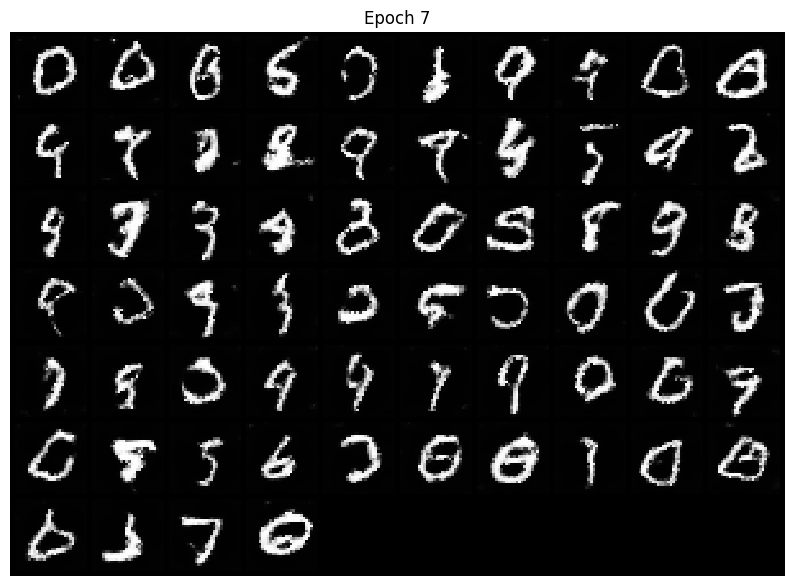

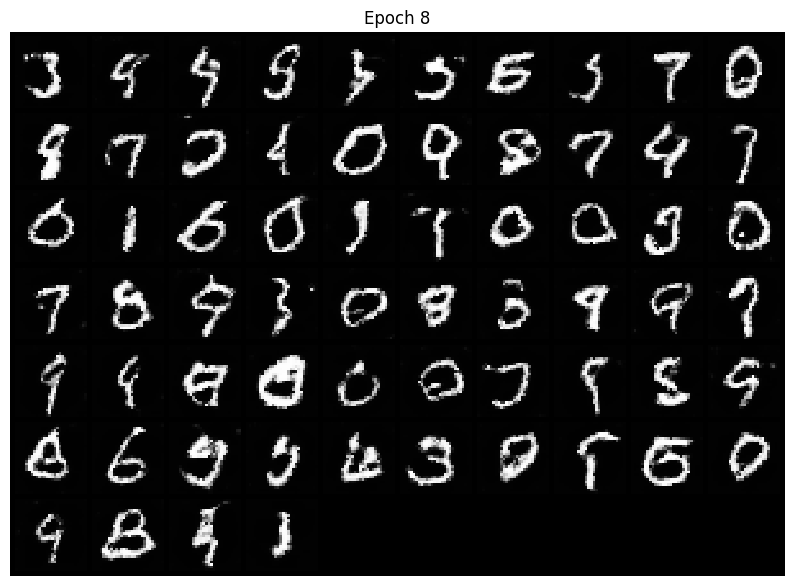

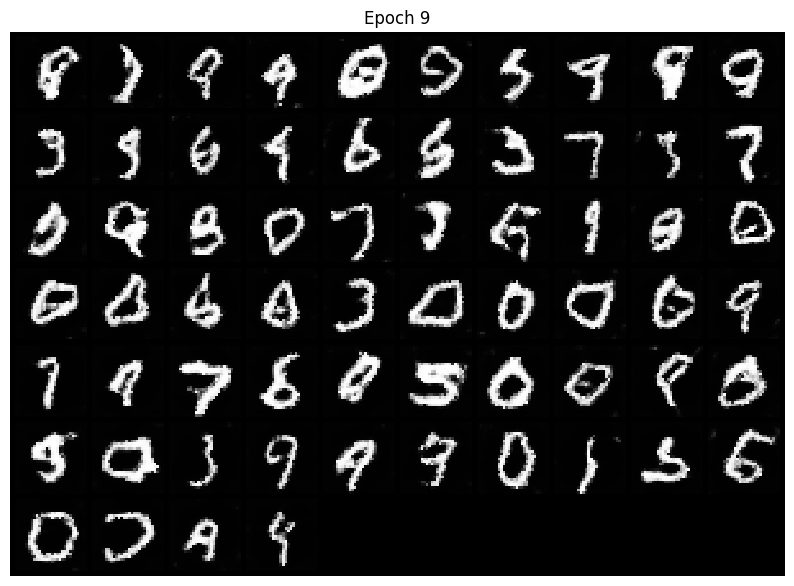

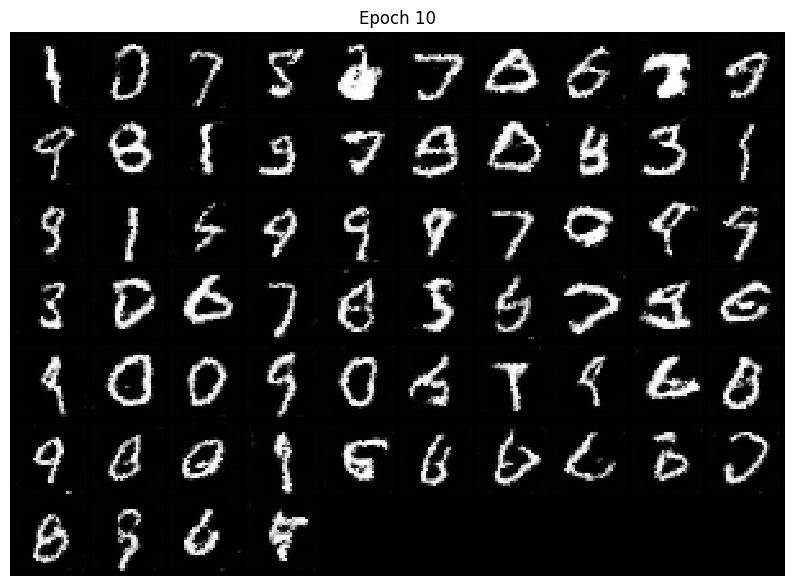

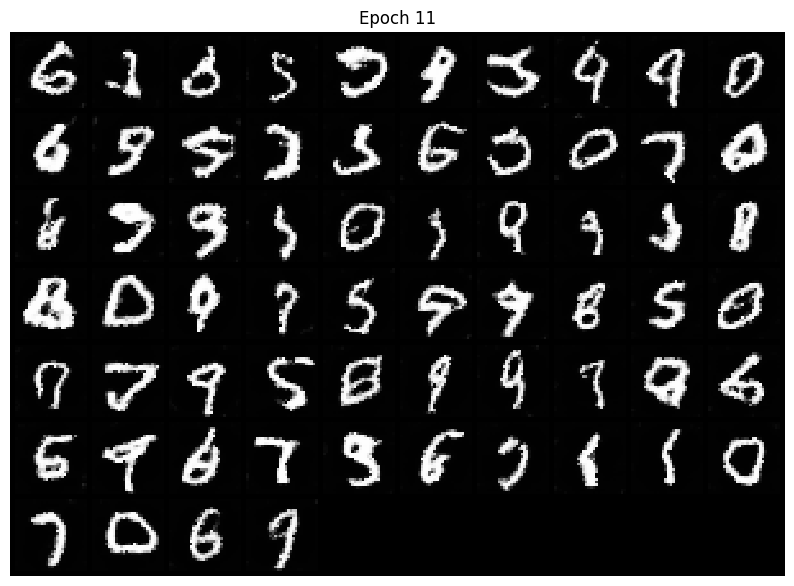

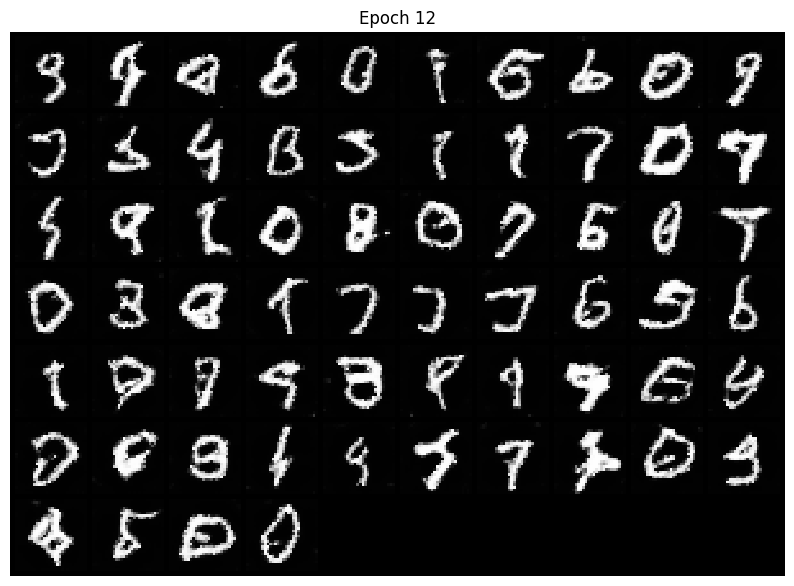

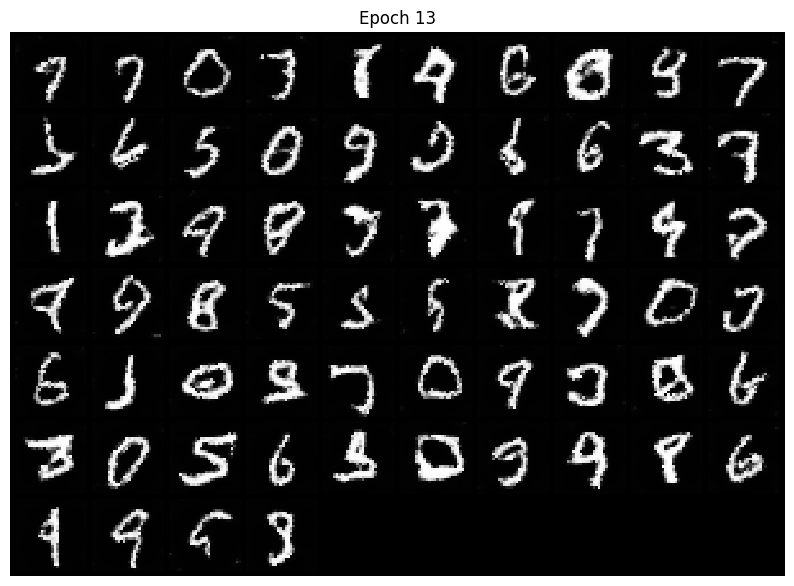

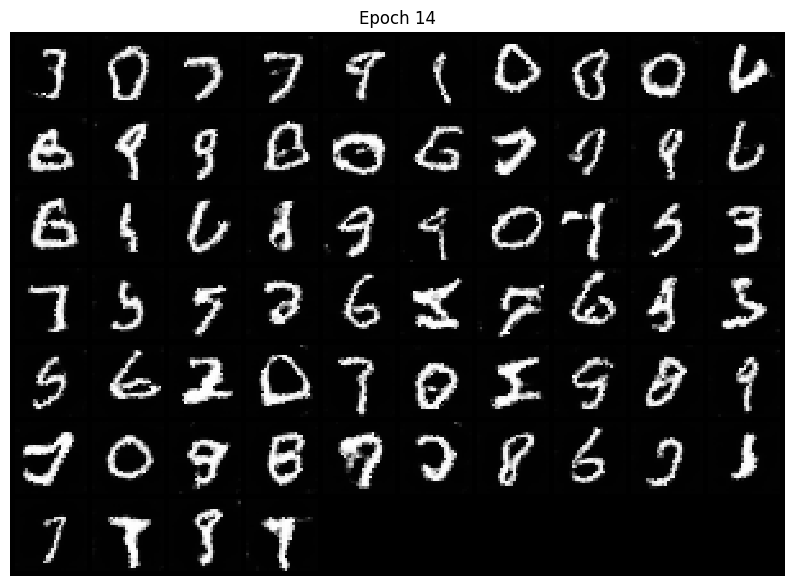

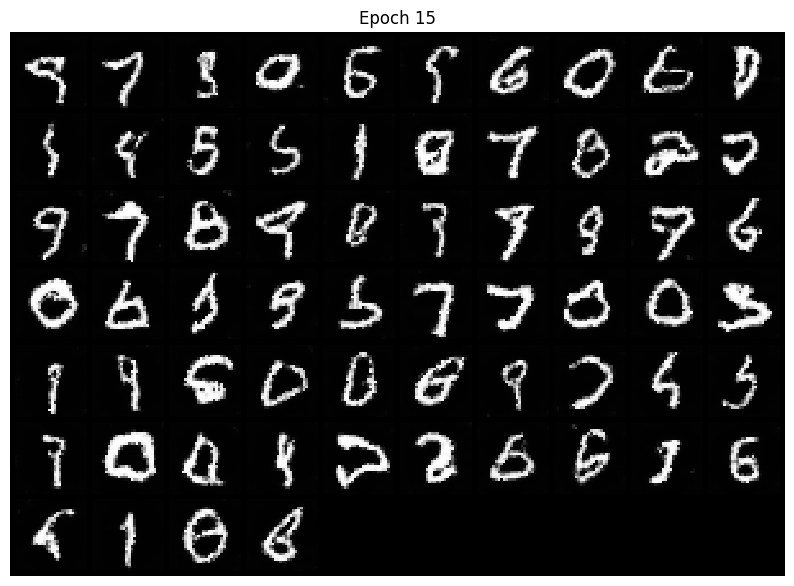

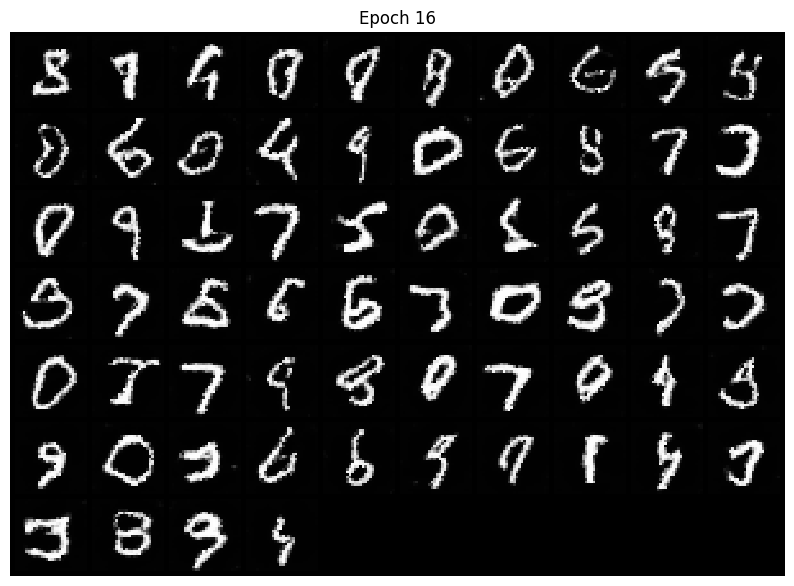

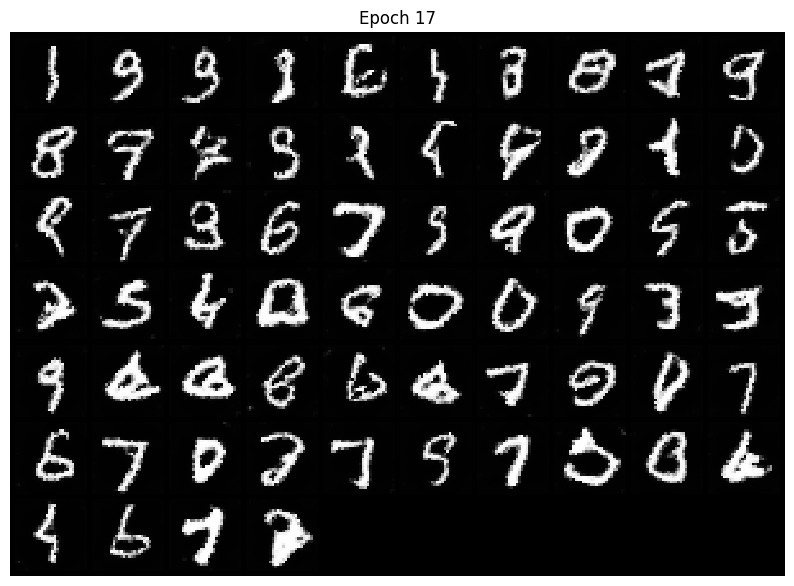

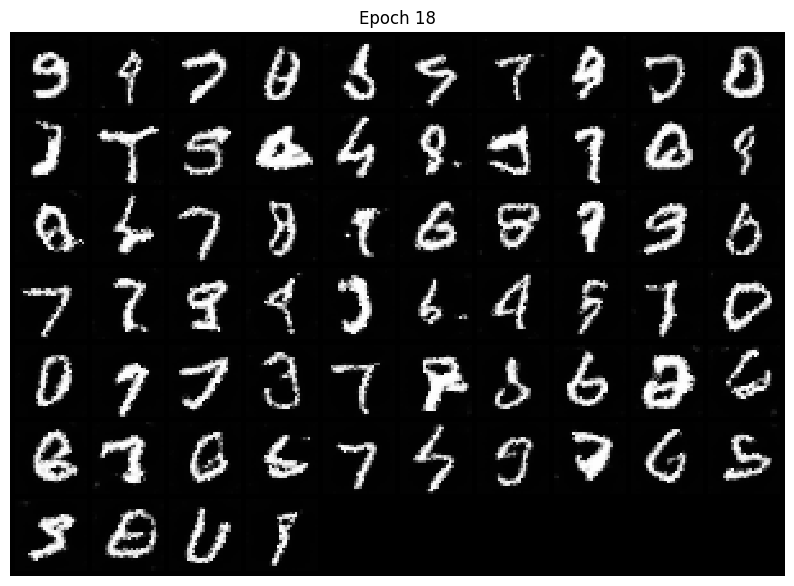

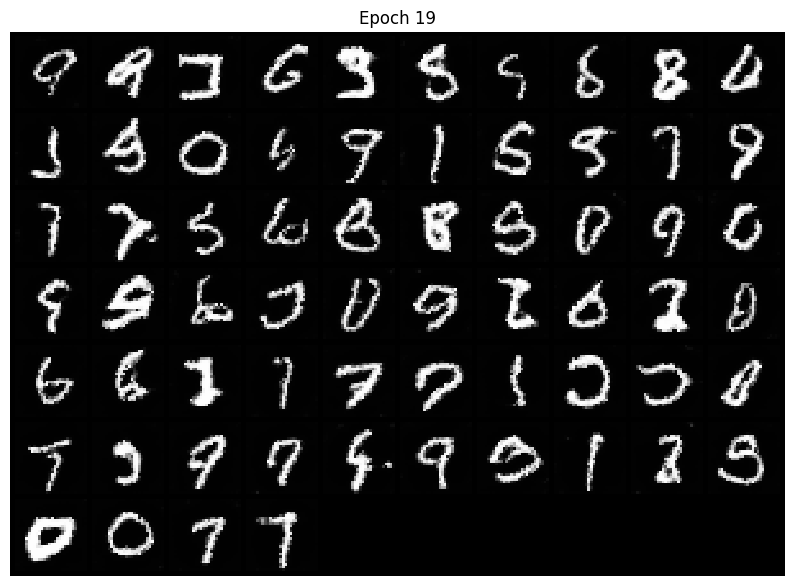

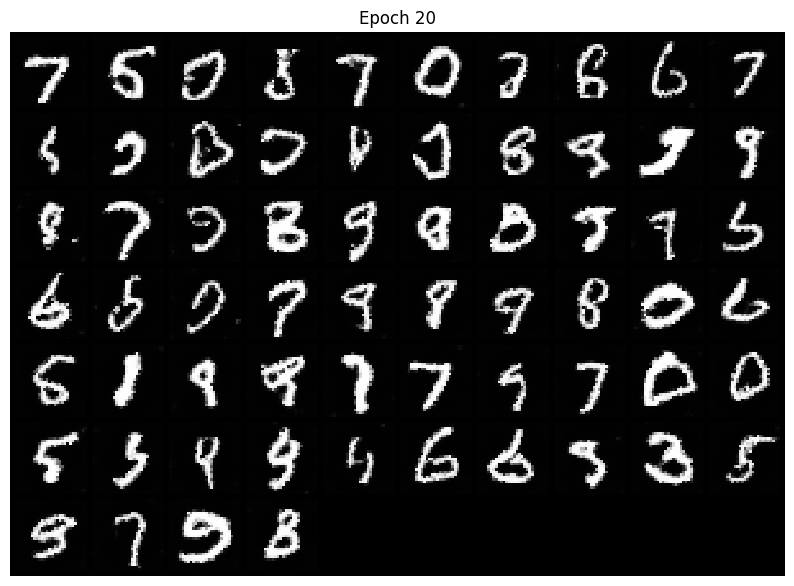

In [11]:
for i, img in enumerate(imgs):
  plt.figure(figsize=(10, 10))
  plt.axis("off")
  plt.imshow(img, interpolation='nearest')
  plt.title(f"Epoch {i+1}")